# 1. Setup

## 1.1 Import Packages

In [1]:
#Import Python packages
import pandas as pd
import json
import matplotlib.pyplot as plt
import seaborn as sns
import json
import datetime
import numpy as np
from matplotlib.gridspec import GridSpec
import matplotlib.cm as cm
import matplotlib.colors as mcolors

# for splitting of the dataset
from sklearn.model_selection import train_test_split

# for encoding/transforming the data
from feature_engine.encoding import OneHotEncoder
from feature_engine.encoding import RareLabelEncoder
from feature_engine.outliers import Winsorizer
from feature_engine.transformation import YeoJohnsonTransformer
from sklearn.preprocessing import MinMaxScaler

#ML-Models: Classification
from xgboost import XGBClassifier
from sklearn import tree
from sklearn.linear_model import LogisticRegression
from sklearn. ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn. ensemble import AdaBoostClassifier

#Building clustering model
from sklearn.cluster import KMeans 

# for getting metrics
from sklearn.metrics import classification_report
from sklearn.metrics import silhouette_score,silhouette_samples

# model selection
from sklearn.model_selection import GridSearchCV

# Import Snowflake modules
from snowflake.snowpark import Session
import snowflake.snowpark.functions as F
import snowflake.snowpark.types as T
from snowflake.snowpark import Window
# Define a simple scoring function
from cachetools import cached

## 1.2 Connect to Snowflake

In [2]:
# Get account credentials from a json file
with open("data_scientist_auth.json") as f:
    data = json.load(f)
    username = data["username"]
    password = data["password"]
    account = data["account"]

# Specify connection parameters
connection_parameters = {
    "account": account,
    "user": username,
    "password": password,
    "role": "TASTY_BI",
    "warehouse": "TASTY_BI_WH",
    "database": "frostbyte_tasty_bytes",
    "schema": "analytics",
}

# Create Snowpark session
session = Session.builder.configs(connection_parameters).create()

In [3]:
session.sql("ALTER WAREHOUSE TASTY_BI_WH SET WAREHOUSE_SIZE = MEDIUM").collect()

[Row(status='Statement executed successfully.')]

## 1.3 Gathering Data as Snowpark DataFrame

In [4]:
# Orders_V
# contains orders, trucks, shift information
tasty_bytes_orders_v = session.table("frostbyte_tasty_bytes.analytics.orders_v")
# Customer Loyalty
# contains information on signed up members
tasty_bytes_customer_loyalty = session.table("frostbyte_tasty_bytes.raw_customer.customer_loyalty")

locations= session.table("frostbyte_tasty_bytes.raw_pos.location")

menu= session.table("frostbyte_tasty_bytes.raw_pos.menu")
#Sentiment_Survey_ds
# contains NPS score
SENTIMENT_DATA = session.table("ngee_ann_polytechnic_frostbyte_data_share.raw_survey.sentiment_survey_ds")
# Truck information data
TRUCK_DATA = session.table("NGEE_ANN_POLYTECHNIC_FROSTBYTE_DATA_SHARE.raw_pos.truck")
# Comparison Data
NPS_COMPARE = session.table("NPS_COMPARE")

# 2. Data Exploration 

## 2.0 Model Value Towards Tasty Byte KPI

### 2.0.1 Define function - Remove Duplicate Columns from Joins

In [5]:
#Function to remove and rename columns after inner join
def remove_dup_join_col(df):
    # capitalise all columns
    for col in df.columns:
        df = df.withColumnRenamed(col, col.upper())
    
    # get list of renamable columns for left and right join
    left_dup_col = [col_name for col_name in df.columns if col_name.startswith('L_')]
    right_dup_col = [col_name for col_name in df.columns if col_name.startswith('R_')]
    old_columns = df.columns
    
    # rename the list with the most number of renamable columns
    # drop the list of columns with less number of renamable columns
    if len(left_dup_col)>len(right_dup_col):
        columns_rename=left_dup_col
        df= df.drop(*right_dup_col)
    else:
        columns_rename=right_dup_col
        df= df.drop(*left_dup_col)
    
    for old_column in old_columns:
        if old_column in columns_rename:
            # get string to remove
            string_to_replace = columns_rename[0][:7]
            # replace starting string
            new_column = old_column.replace(string_to_replace, "")
            df = df.withColumnRenamed(old_column, new_column)
    
    return df

# 3. Data Engineering

## 3.1 Generate new Columns

In [6]:
#Merge to get loyal customers orders
loyal_customer_orders=tasty_bytes_orders_v.join(
    right=tasty_bytes_customer_loyalty,
    on="CUSTOMER_ID",
    how="inner"
)

In [7]:
#Remove duplicate columns
loyal_customer_orders = remove_dup_join_col(loyal_customer_orders)

#Remove duplicate order ids
remove_dup = loyal_customer_orders.dropDuplicates(['ORDER_ID'])

In [8]:
# called `orders` with columns `customer_id` and `order_ts`
window_spec = Window.partitionBy('customer_id').orderBy(F.col('order_ts').desc())

orders_with_rank = remove_dup.withColumn('rank', F.rank().over(window_spec))

# Get max order of each customer
max_order_ts = orders_with_rank.filter(F.col('rank') == 1).select('customer_id', 'order_ts')

In [9]:
# Rename columns
max_order_ts = max_order_ts.withColumnRenamed('ORDER_TS','Max_Order_TS')

In [10]:
# Merge with second max order dataframe
max_Order=remove_dup.join(right=max_order_ts,on='CUSTOMER_ID',how='inner')

#Filter out last purchase
filtered_df = max_Order.filter(F.col('ORDER_TS') < F.col('Max_Order_TS'))

### 3.1.2 RFM (Recency, Freqency, Monetary)

In [11]:
# Get last purchase date as a variable
lastdate=filtered_df.select(F.max('ORDER_TS')).first()[0]

# Recency
recency = filtered_df.groupBy('CUSTOMER_ID').agg(F.max('ORDER_TS').alias('ORDER_TS'))
recency = recency.withColumn('RECENCY', F.datediff(col1=F.col('ORDER_TS'), col2=F.lit(lastdate),part='day'))

# Frequency
frequency = filtered_df.groupBy('CUSTOMER_ID').agg(F.countDistinct('ORDER_ID').alias('frequency'))

# Monetary
monetary = filtered_df.groupBy('CUSTOMER_ID').agg(F.sum('ORDER_TOTAL').alias('monetary'))

# Merge into RFM table
RFM_table = recency.join(frequency, on='CUSTOMER_ID', how='inner')
RFM_table = RFM_table.join(monetary, on='CUSTOMER_ID', how='inner')


This code is used to get RFM, Recency, Frequency, and Monetary for each customer. The purpose of doing this is to generate new features and show the customer's behavioural data.

### 3.1.3 Average Time Difference, Max and Min Days without Purchase

In [12]:
# Define a window partitioned by customer and menu item, ordered by date
window_spec = Window.partitionBy("CUSTOMER_ID").orderBy("DATE")

# Add a column with the date of the prior order for each customer 
orders_df = filtered_df.withColumn("DAYS_SINCE_PRIOR_ORDER", F.lag("DATE").over(window_spec))

# Calculate the number of days between the prior order and the current order for each customer and menu item
orders_df = orders_df.withColumn("DAYS_SINCE_PRIOR_ORDER", F.datediff(col1="DAYS_SINCE_PRIOR_ORDER", col2="DATE",part='day'))
orders_df = orders_df.na.drop(subset=["DAYS_SINCE_PRIOR_ORDER"])

# Calculate the average purchase time difference for each customer
avg_time_diff=orders_df.group_by('CUSTOMER_ID').agg(F.round(F.avg('DAYS_SINCE_PRIOR_ORDER'),0).alias('Avg_Days_Between_Purchase'))

# Max Days without Purchase
max_days=orders_df.group_by('CUSTOMER_ID').agg(F.max('DAYS_SINCE_PRIOR_ORDER').alias('Max_Days_Without_Purchase'))

# Min Days without Purchase
min_days=orders_df.group_by('CUSTOMER_ID').agg(F.min('DAYS_SINCE_PRIOR_ORDER').alias('Min_Days_Without_Purchase'))

This code is used to get the average purchase time difference for each customers. This is done by calculating the most number of days a customer has gone without purchasing and the least number of days the customer has gone without purchasing. These features are also to show the behavioural information of each customer.

### 3.1.4 Creating Age and getting Customer's Gender, Marital Status and Country

In [13]:
# Get Customer demographic
cust_demo=tasty_bytes_customer_loyalty.select('CUSTOMER_ID','BIRTHDAY_DATE','GENDER','MARITAL_STATUS','COUNTRY','CITY','SIGN_UP_DATE','CHILDREN_COUNT')

# get AGE variable
cust_demo = cust_demo.withColumn("AGE", F.datediff('year', F.col("BIRTHDAY_DATE"),F.lit(lastdate)))

# Show
cust_demo.show()

---------------------------------------------------------------------------------------------------------------------------------------------
|"CUSTOMER_ID"  |"BIRTHDAY_DATE"  |"GENDER"     |"MARITAL_STATUS"  |"COUNTRY"  |"CITY"          |"SIGN_UP_DATE"  |"CHILDREN_COUNT"  |"AGE"  |
---------------------------------------------------------------------------------------------------------------------------------------------
|1              |1953-12-01       |Female       |Single            |Germany    |Hamburg         |2019-02-19      |0                 |69     |
|2              |1973-09-21       |Male         |Single            |Brazil     |Rio de Janeiro  |2019-10-07      |0                 |49     |
|3              |2000-09-04       |Female       |Married           |Poland     |Krakow          |2020-09-11      |2                 |22     |
|4              |1950-03-05       |Female       |Single            |Poland     |Krakow          |2021-09-09      |1                 |72     |
|5    

We added a new column called "AGE" which contains the age of the customer at the time of the latest transaction. We also retrieved new columns like the customer's gender, marital status and country.

### Attempted Improvements to the model

#### Improved the Model

In [14]:
# Number of locations visited
num_of_locations_visited=filtered_df.group_by('CUSTOMER_ID').agg(F.countDistinct('LOCATION_ID').alias('NUM_OF_LOCATIONS_VISITED'))

In [15]:
# Add Length of relationship

window_spec = Window.partitionBy('customer_id').orderBy(F.col('order_ts').asc())

orders_with_rank = filtered_df.withColumn('rank', F.rank().over(window_spec))

# Get max order of each customer
first_order_ts = orders_with_rank.filter(F.col('rank') == 1).select('customer_id', 'order_ts')

# Join the first_orders and last_orders DataFrames on customer_id
joined_orders = first_order_ts.join(max_order_ts, 'customer_id')

# Calculate the difference in days between the first and last order
diff_in_days = joined_orders.withColumn('Length_of_Relationship', F.datediff(col1='order_ts', col2='max_order_ts',part='day'))

diff_in_days=diff_in_days.drop(['ORDER_TS','MAX_ORDER_TS'])

diff_in_days.show()

--------------------------------------------
|"CUSTOMER_ID"  |"LENGTH_OF_RELATIONSHIP"  |
--------------------------------------------
|209298         |991                       |
|124730         |1258                      |
|34083          |1020                      |
|64747          |901                       |
|104694         |1208                      |
|130939         |1011                      |
|139560         |1001                      |
|134772         |1287                      |
|63524          |1162                      |
|158145         |1019                      |
--------------------------------------------



### 3.1.5 Join Generated Variables

In [16]:
# Merge to get final dataframe
final_df = RFM_table.join(max_order_ts, on='CUSTOMER_ID', how='inner')
final_df = final_df.join(avg_time_diff, on='CUSTOMER_ID', how='inner')
final_df = final_df.join(max_days, on='CUSTOMER_ID', how='inner')
final_df = final_df.join(min_days, on='CUSTOMER_ID', how='inner')
final_df = final_df.join(cust_demo,on='CUSTOMER_ID',how='inner')
final_df = final_df.join(diff_in_days,on='CUSTOMER_ID',how='inner')
final_df = final_df.join(num_of_locations_visited,on='CUSTOMER_ID',how='inner')

We joined all the different tables to get all the columns in the same table by inner joining all the different tables on the CUSTOMER_ID column. The joined table contains all the different features we will be using to predict the target.

#### Attempted Improvement: Created Relative Purchase Frequency and Monetary

In [17]:
final_df=final_df.with_column('RELATIVE_PURCHASE_FREQUENCY',(F.col('FREQUENCY')/F.col('Length_of_Relationship')).cast('float'))
final_df=final_df.with_column('RELATIVE_PURCHASE_MONETARY',(F.col('MONETARY')/F.col('Length_of_Relationship')).cast('float'))

### 3.1.7 Filter to selected Country

In [18]:
# Filter to United States
final_df=final_df.filter(F.col('COUNTRY')=='United States')

We filtered the data to only have records for the United States. This is because we are only interested in the United States as shown above due to its high churn rate and high number of customers

In [19]:
# Sort CustomerID
final_df=final_df.sort('CUSTOMER_ID')

In [20]:
# Convert to pandas
final_df=final_df.to_pandas()

We converted the table to pandas because we want to carry out data manipulation.

## 3.2 Outlier Handling

### 3.2.1 Identify Numericals

In [21]:
num_cols=final_df.select_dtypes(exclude=['object','datetime64[ns]']).columns

### 3.2.2 Visualise Outliers

In [22]:
# Function to explore the distributuion of variables
def diagnostic_plots(df, variable):
    # function takes a dataframe (df) and
    # the variable of interest as arguments

    # define figure size
    fig=plt.figure(figsize=(12, 4))
    fig.suptitle(variable)
    
    # histogram
    plt.subplot(1, 2, 1)
    sns.histplot(df[variable], bins=30,kde=True)
    plt.title('Histogram')

    # boxplot
    plt.subplot(1, 2, 2)
    sns.boxplot(y=df[variable])
    plt.title('Boxplot')
    
    plt.show()

In [23]:
# function to create before and after histogram
def before_after_histogram(df_before,df_after, variable):
    # function takes a dataframe (df) and
    # the variable of interest as arguments

    # define figure size
    plt.figure(figsize=(16, 4))

    # histogram
    plt.subplot(1, 2, 1)
    sns.histplot(df_before[variable], bins=30)
    plt.title('Before')

    # histogram
    plt.subplot(1, 2, 2)
    sns.histplot(df_after[variable], bins=30)
    plt.title('After')

    plt.suptitle(variable)

    plt.show()

### 3.2.3 Cap the Outliers

#### 3.2.3.1 Cap by IQR

In [24]:
# create the capper
windsorizer = Winsorizer(capping_method='iqr', # choose iqr for skewed or gaussian for normal
                          tail='both', # cap left, right or both tails 
                          fold=3,
                          variables=['RECENCY','AVG_DAYS_BETWEEN_PURCHASE','MAX_DAYS_WITHOUT_PURCHASE'])

windsorizer.fit(final_df)


Winsorizer(capping_method='iqr', tail='both',
           variables=['RECENCY', 'AVG_DAYS_BETWEEN_PURCHASE',
                      'MAX_DAYS_WITHOUT_PURCHASE'])

In [25]:
final_df_win = windsorizer.transform(final_df)

Cap by IQR for distributions with high skewness. (Outliers = 75th percentile onwards)

#### 3.2.3.2 Cap by Gaussian

In [26]:
# create the capper
windsorizer = Winsorizer(capping_method='gaussian', # choose iqr for skewed or gaussian for normal
                          tail='both', # cap left, right or both tails 
                          fold=3,
                          variables=['FREQUENCY','MONETARY'])

windsorizer.fit(final_df_win)

Winsorizer(tail='both', variables=['FREQUENCY', 'MONETARY'])

In [27]:
final_df_win = windsorizer.transform(final_df_win)

Cap by gaussian for distributions with a normal ditribution. (Outliers = 3 Standard-deviations away)

It can be seen that much of the outliers have been 'Capped' where all values above a certain threshold are placed at the uppermost limit. This ensures that the machine learning model will not be trained for anomalies and outliers but for the majority of members

We see that AVG_DAYS_BETWEEN_PURCHASE and MAX_DAYS_WITHOUT_PURCHASE has had a significant amount of outlier handling done, where the maximum values for both have been halved, down from 70 to 45 and 800 to 350 respectively.

By reducing the variable range, it helps the model focus on the key patterns and relationships within the majority of the data.

## 3.3 Numerical Transformation

### 3.3.1 Visualise Numericals

### 3.3.2 YeoJohnson Transformer

In [28]:
# create untransformed copy of the dataframe for customer segmentation
cust_seg_ori = final_df_win.copy()

In [29]:
# select variables to transform in a list
cols = ['RECENCY', 'AVG_DAYS_BETWEEN_PURCHASE', 'MAX_DAYS_WITHOUT_PURCHASE']

# initialize the transformer with a subset of variables to transform
yjt = YeoJohnsonTransformer(variables = cols)

# fit transformer to the dataframe
yjt.fit(final_df_win)

YeoJohnsonTransformer(variables=['RECENCY', 'AVG_DAYS_BETWEEN_PURCHASE',
                                 'MAX_DAYS_WITHOUT_PURCHASE'])

In [30]:
# transform indicated variables
final_df_yjt = yjt.transform(final_df_win)

It can be seen that the 3 variables to be transformed have achieved a more normal distribution. This ensures that the model avoids overfitting to the random noise of the data by reducing the variable range further, as well as further mitigates the effects of outliers.

# K-Means

In [31]:
# function to create change in silhoutte score and change against number of clusters
def sse_eval(sse):
    
    percentage_change = [(sse[i+1] - sse[i]) / sse[i] * 100 for i in range(len(sse)-1)]

    # define figure size
    plt.figure(figsize=(16, 4))

    # regular
    plt.subplot(1, 2, 1)
    plt.plot(range(1, 11), sse, 'b-*')
    plt.title('Actual SSE')
    plt.xlabel('Number of clusters')
    plt.ylabel('SSE')

    # difference
    plt.subplot(1, 2, 2)
    plt.plot(range(1, 10), percentage_change, 'b-*')
    plt.title('% change in SSE')
    plt.xlabel('Number of clusters')
    plt.ylabel('% Change')

    plt.suptitle('Sum of Squared Errors')

    plt.show()

In [32]:
rfm_Table=cust_seg_ori[['RECENCY','FREQUENCY','MONETARY']]

In [33]:
# With AGE	LENGTH_OF_RELATIONSHIP
# Min Max Scaler
rfm_Table_Scaled=rfm_Table.copy()
scaler = MinMaxScaler()

# fit the scaler to the train set, it will learn the parameters
scaler.fit(rfm_Table[['RECENCY','FREQUENCY','MONETARY']])

# transform train and test sets
rfm_Table_Scaled[['RECENCY','FREQUENCY','MONETARY']]= scaler.transform(rfm_Table[['RECENCY','FREQUENCY','MONETARY']])

In [34]:
# Find the optimal number of clusters (i.e. K) using elbow method
sse = []
for i in range(1, 11):
    kmeans = KMeans(n_clusters=i, n_init=20, random_state=1)
    kmeans.fit(rfm_Table_Scaled)
    sse.append(kmeans.inertia_)

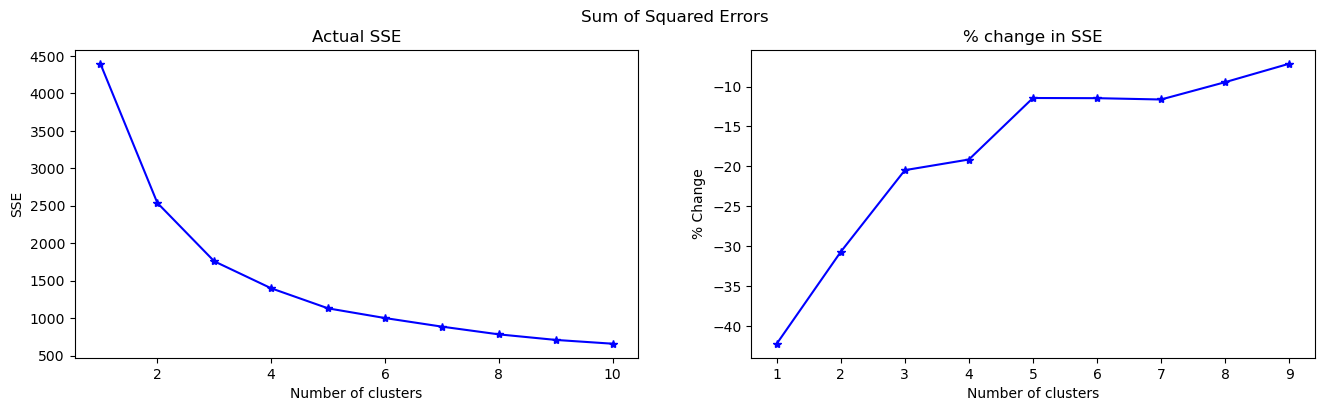

In [35]:
sse_eval(sse)

In [36]:
# num of clusters
num_of_k_means_clusters = 5
# Build a K-means clustering model
km = KMeans(n_clusters=num_of_k_means_clusters, n_init=20, max_iter=300, random_state=1)
# Fit the Model on our dataset
km.fit(rfm_Table_Scaled)
# Assign each data object/point to the cluster represented by its nearest centroid
y_pred = km.predict(rfm_Table_Scaled)

In [37]:
# Define a custom color palette
custom_palette_k_means = sns.color_palette("tab10", n_colors=num_of_k_means_clusters)
custom_palette_k_means

[(0.12156862745098039, 0.4666666666666667, 0.7058823529411765),
 (1.0, 0.4980392156862745, 0.054901960784313725),
 (0.17254901960784313, 0.6274509803921569, 0.17254901960784313),
 (0.8392156862745098, 0.15294117647058825, 0.1568627450980392),
 (0.5803921568627451, 0.403921568627451, 0.7411764705882353)]

In [38]:
# Add in cluster information into original dataframe (dat)
rfm_Table['kmeans_cluster']=y_pred
rfm_Table_Scaled['kmeans_cluster']=y_pred

C:\Users\ryanl\AppData\Local\Temp\ipykernel_26680\289811850.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rfm_Table['kmeans_cluster']=y_pred


In [39]:
#test=rfm_Table.copy() #this is with the las torder

C:\Users\ryanl\AppData\Local\Temp\ipykernel_26680\3805783098.py:16: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for row_key, (ax,row) in box.iteritems():
C:\Users\ryanl\AppData\Local\Temp\ipykernel_26680\3805783098.py:16: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for row_key, (ax,row) in box.iteritems():
C:\Users\ryanl\AppData\Local\Temp\ipykernel_26680\3805783098.py:16: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for row_key, (ax,row) in box.iteritems():


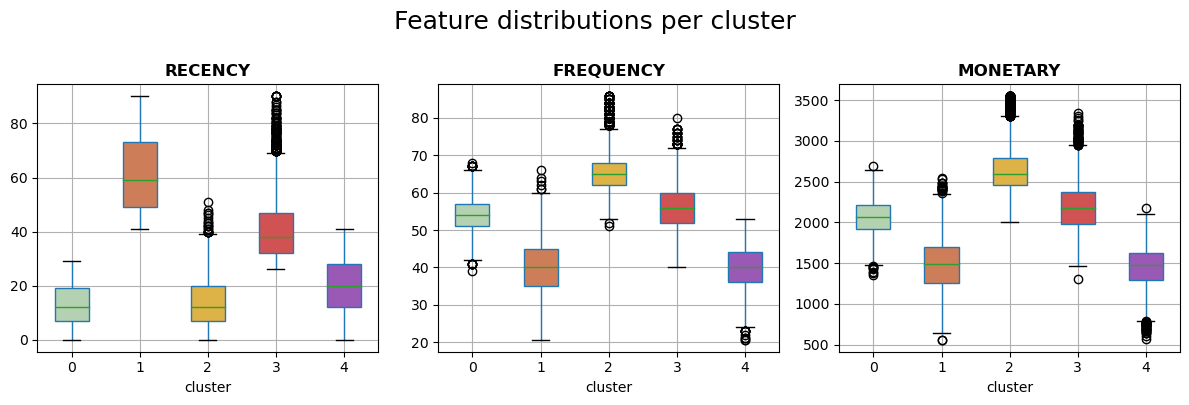

In [40]:
cluster_colors = ['#b4d2b1', '#cd7e59', '#ddb247', '#d15252', '#9b59b6', '#3498db', '#f39c12']
# Add in cluster information into original dataframe (dat)


# Groupped Boxplots

features = ['RECENCY','FREQUENCY','MONETARY']
ncols = 3
nrows = len(features) // ncols + (len(features) % ncols > 0)
fig = plt.figure(figsize=(12,4))

for n, feature in enumerate(features):
    ax = plt.subplot(nrows, ncols, n + 1)
    box = rfm_Table[[feature, 'kmeans_cluster']].boxplot(by='kmeans_cluster',ax=ax,return_type='both',patch_artist = True)

    for row_key, (ax,row) in box.iteritems():
        ax.set_xlabel('cluster')
        ax.set_title(feature,fontweight="bold")
        for i,box in enumerate(row['boxes']):
            box.set_facecolor(cluster_colors[i])

fig.suptitle('Feature distributions per cluster', fontsize=18, y=1)   
plt.tight_layout()
plt.show()

In [41]:
analysis_df=rfm_Table[['RECENCY','FREQUENCY','MONETARY','kmeans_cluster']]

In [42]:
# Step 1: Group the DataFrame by 'kmeans_cluster'
cluster_groups = analysis_df.groupby('kmeans_cluster')

# Step 2: Iterate through each cluster group and apply .info() function
for cluster, cluster_df in cluster_groups:
    print(f"Cluster {cluster} Description:")
    print(cluster_df.describe())
    print("------------")

Cluster 0 Description:
            RECENCY     FREQUENCY      MONETARY  kmeans_cluster
count  15177.000000  15177.000000  15177.000000         15177.0
mean      13.067668     54.285564   2062.624646             0.0
std        7.122689      4.373209    201.630990             0.0
min        0.000000     39.000000   1348.750000             0.0
25%        7.000000     51.000000   1917.750000             0.0
50%       12.000000     54.000000   2070.000000             0.0
75%       19.000000     57.000000   2214.250000             0.0
max       29.000000     68.000000   2690.000000             0.0
------------
Cluster 1 Description:
           RECENCY    FREQUENCY     MONETARY  kmeans_cluster
count  3896.000000  3896.000000  3896.000000          3896.0
mean     61.972279    39.951761  1484.978976             1.0
std      14.789746     7.405753   319.546959             0.0
min      41.000000    20.686715   562.670357             1.0
25%      49.000000    35.000000  1256.187500             1.0

**Cluster 0: "Active Moderate-Value Customers"**
- Description: This cluster represents customers who are active, show moderate recency (recent purchases), and have a moderate level of spending (moderate monetary value).

**Cluster 1: "Inactive Low-Spending Customers"**
- Description: This cluster consists of customers who exhibit high recency (longest inactivity), low spending (lowest monetary value), and have low purchase frequency (low frequency). These customers are currently inactive and have not made recent purchases.

**Cluster 2: "High-Value Loyal Customers"**
- Description: This cluster includes customers who are both high-value and highly loyal to the business. They have moderate recency (recent purchases), a high purchase frequency (high frequency), and spend significantly (high monetary value). These customers are the most valuable and loyal members, representing a critical segment for the business's ongoing success.

**Cluster 3: "Engaged Moderate-Value Customers"**
- Description: This cluster comprises customers who show moderate recency (recent purchases), a moderate purchase frequency (moderate frequency), and have a moderate level of spending (moderate monetary value). They are actively engaged with the brand and contribute to the business's success.

**Cluster 4: "Active Low-Spending Customers"**
- Description: This cluster consists of customers who have made recent purchases (moderate recency), but their spending is relatively low (low monetary value). They exhibit moderate purchase frequency (moderate frequency) and represent an active but low-spending segment.

In [43]:
X = rfm_Table_Scaled.drop(['kmeans_cluster'], axis =1,
                  errors='ignore')
y = rfm_Table_Scaled["kmeans_cluster"]


X_train,X_test,y_train,y_test=train_test_split(X,y,test_size=0.6,random_state=42)

In [44]:
# Test and holdout split
X_test,X_holdout,y_test,y_holdout=train_test_split(X_test,y_test,test_size=0.5,random_state=42)

In [45]:
# Function to show MSE, MAE, r-sq of Classification models
def evaluateModel(model):

    print('Train Accuracy: \t{:.2f}%  \
          \nTest Accuracy: \t\t{:.2f}%  \
          \nHoldout Accuracy: \t{:.2f}%'.format(model.score(X_train, y_train)*100,model.score(X_test, y_test)*100,model.score(X_holdout, y_holdout)*100))

## Logistic Regression

In [46]:
# Build Logistic Regression Model
log_ref_before = LogisticRegression(max_iter=10000)
log_ref_before.fit(X_train, y_train)

evaluateModel(log_ref_before)

Train Accuracy: 	97.72%            
Test Accuracy: 		97.83%            
Holdout Accuracy: 	97.65%


In [47]:
# Use GridSearch to find the best combination of model hyperparameters

logreg = LogisticRegression()
param_grid = {"penalty": ["l2"],
                "C" : [0.1, 1, 10],
                "solver" : ["newton-cg", "lbfgs", "liblinear"]}

gs =GridSearchCV(logreg, param_grid = param_grid, scoring = "accuracy", cv = 10, n_jobs = -1)
gs = gs.fit(X_train, y_train)

lr_best_score=gs.best_score_
print(gs.best_score_)
print(gs.best_params_)

0.989902807775378
{'C': 10, 'penalty': 'l2', 'solver': 'newton-cg'}


In [48]:
# Build Logistic Regression Model
log_ref_improved = LogisticRegression(**gs.best_params_)
log_ref_improved.fit(X_train, y_train)

evaluateModel(log_ref_improved)

Train Accuracy: 	99.04%            
Test Accuracy: 		99.17%            
Holdout Accuracy: 	99.10%


## Decision Tree

In [50]:
# Build Decision Tree Model
decision_tree_before = tree.DecisionTreeClassifier(max_depth = 20)

decision_tree_before.fit(X_train, y_train)

evaluateModel(decision_tree_before)

Train Accuracy: 	100.00%            
Test Accuracy: 		98.25%            
Holdout Accuracy: 	98.39%


In [51]:
dt = tree.DecisionTreeClassifier()

param_grid = { "criterion" : ["gini", "entropy"], 
              "min_samples_leaf" : [1, 5, 10,20,30,40,50,100], 
              "min_samples_split" : [2, 4, 10, 12, 16], 
              'max_depth' : [2,3,4,5,6,7]}

gs = GridSearchCV(dt, param_grid=param_grid, scoring='accuracy', cv= 5, n_jobs=-1)
# cv: number of partitions for cross validation
# n_jobs: number of jobs to run in parallel, -1 means using all processors

gs = gs.fit(X_train, y_train) 
dt_best_score=gs.best_score_

print(gs.best_score_)
print(gs.best_params_)

0.9624190064794818
{'criterion': 'entropy', 'max_depth': 7, 'min_samples_leaf': 10, 'min_samples_split': 2}


In [52]:
# Create Decision Tree using the best hyperparameters
decision_tree_improved = tree.DecisionTreeClassifier(**gs.best_params_)
decision_tree_improved.fit(X_train, y_train)

evaluateModel(decision_tree_improved)

Train Accuracy: 	96.95%            
Test Accuracy: 		96.41%            
Holdout Accuracy: 	96.04%


## Random Forest

In [53]:
# Build Random Forest Model
random_forest_before= RandomForestClassifier(n_estimators=100)
random_forest_before.fit(X_train, y_train)

evaluateModel(random_forest_before)

Train Accuracy: 	100.00%            
Test Accuracy: 		98.96%            
Holdout Accuracy: 	98.94%


In [54]:
rf = RandomForestClassifier()
param_grid = {'n_estimators': [10, 50, 100],
'max_depth': [ 4, 6, 8],
'min_samples_split': [5, 10, 15]}

gs = GridSearchCV(rf, param_grid = param_grid, scoring = "accuracy", cv = 5, n_jobs = -1)
gs = gs.fit(X_train, y_train)

rf_best_score=gs.best_score_
print(gs.best_score_)
print(gs.best_params_)

0.9766738660907126
{'max_depth': 8, 'min_samples_split': 5, 'n_estimators': 100}


In [55]:
# Build RandomForest Model and Evaluate both training and testing accuracy
random_forest_improved = RandomForestClassifier(**gs.best_params_)
random_forest_improved.fit(X_train,y_train)

evaluateModel(random_forest_improved)

Train Accuracy: 	98.74%            
Test Accuracy: 		97.82%            
Holdout Accuracy: 	97.75%


## Adaboost

In [56]:
# Build Ada Boost Model
adb_before = AdaBoostClassifier(DecisionTreeClassifier(),n_estimators=5,learning_rate=1)
adb_before.fit(X_train, y_train)

evaluateModel(adb_before)

Train Accuracy: 	100.00%            
Test Accuracy: 		98.31%            
Holdout Accuracy: 	98.32%


In [57]:
adb = AdaBoostClassifier()

param_grid = {
    'estimator': [tree.DecisionTreeClassifier(max_depth=1), tree.DecisionTreeClassifier(max_depth=2)],
    'n_estimators': [50, 100, 200],
    'learning_rate': [0.1, 0.5, 1],
    'algorithm': ['SAMME', 'SAMME.R']
}

gs = GridSearchCV(adb, param_grid, cv=5, n_jobs=-1)

gs.fit(X_train, y_train)

adb_best_score=gs.best_score_
print(gs.best_score_)
print(gs.best_params_)

0.9605831533477323
{'algorithm': 'SAMME', 'estimator': DecisionTreeClassifier(max_depth=2), 'learning_rate': 1, 'n_estimators': 100}


In [58]:
# Build Ada Boost Model and Evaluate both training and testing accuracy
adb_improved = AdaBoostClassifier(**gs.best_params_)
adb_improved.fit(X_train,y_train)

evaluateModel(adb_improved)

Train Accuracy: 	95.97%            
Test Accuracy: 		96.08%            
Holdout Accuracy: 	95.87%


## XGboost (Final Model)

In [59]:
# Build XGBoost Model
xgb_before= XGBClassifier(n_estimators = 20, learning_rate = 0.1, eval_metric='logloss',max_depth = 20)
xgb_before.fit(X_train, y_train)

#E valuate XGBoost Model
evaluateModel(xgb_before)

Train Accuracy: 	99.88%            
Test Accuracy: 		98.73%            
Holdout Accuracy: 	98.78%


In [60]:
xgb = XGBClassifier()

param_grid = {
    'max_depth': [4, 6, 8], 
    'learning_rate': [0.05, 0.1, 0.2],
    'n_estimators': [20, 50, 100],
    'subsample':[0.6,0.7,0.8]
}

gs = GridSearchCV(xgb_before, param_grid, cv=5, n_jobs=-1,scoring='accuracy')

gs.fit(X_train, y_train)

xgb_best_score=gs.best_score_
print(gs.best_score_)
print(gs.best_params_)

0.9898488120950324
{'learning_rate': 0.2, 'max_depth': 4, 'n_estimators': 100, 'subsample': 0.6}


In [61]:
# Build XGBoost Model and Evaluate both training and testing accuracy 
xgb_improved = XGBClassifier(**gs.best_params_)
xgb_improved.fit(X_train,y_train)

evaluateModel(xgb_improved)

Train Accuracy: 	99.94%            
Test Accuracy: 		99.26%            
Holdout Accuracy: 	99.27%


In [62]:
y_pred= xgb_improved.predict(X_test)

In [63]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.99      0.99      0.99      4583
           1       0.99      0.99      0.99      1173
           2       1.00      0.99      1.00      3428
           3       0.99      0.99      0.99      2045
           4       0.99      0.99      0.99      2661

    accuracy                           0.99     13890
   macro avg       0.99      0.99      0.99     13890
weighted avg       0.99      0.99      0.99     13890

